<a href="https://colab.research.google.com/github/jmdelvecchio/ears33/blob/main/Glaciality_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Glaciers and rivers are both powerful enough to shape the valley profile of a landscape. It has long been understood that, as the world transitions from glacial to interglacial periods, fluvial systems inhabit previously glacially-formed valleys. However, little is known about why this trantision happens in some cases, and why, in other cases, U-shaped glacial profiles persist through interglacial periods. A recent study suggested this phenomenon could be answered by tectonic activity. In this data tutorial, I will take river profiles from different regions of the US, quantitatively assess their shapes, and compare these profiles against the known erosion rates for the watersheds from which these profiles were taken. 

I began by choosing my watersheds using https://octopusdata.org. This dataset provides watershed areas and respective Beryllium-10 erosion rates for each watershed. I chose a New York watershed (Northern Susquehanna) and a California watershed (Northern California Coastal). I have included a map of the watersheds as a final in this submission. Then I took 10m Digital Elevation Model (DEM) data from the USGS website for each of these regions. I uploaded these files into ArcMap, then chose several river profiles using the 3D Analyst tool for each watershed to analyze. These profiles produced data for distance vs elevation that I exported as a .csv file and upload in this data tutorial.

As for data wrangling/manipulation, in this tutorial I take the river profiles, split them into two flanks (right and left) then fit a power law on each flank (y=ax^b). This b value is what I use to quantify the V-ness or U-ness of each profile. I will explain these steps in further detail later. 

This data tutorial is adapted from Prasicek, G., Larsen, I. & Montgomery, D. "Tectonic control on the persistence of glacially sculpted topography." *Nature Communications* 6, 8028 (2015). https://doi.org/10.1038/ncomms9028

In [ ]:
# ONLY RUN THIS BLOCK OF CODE FOR THE FIRST RUN 
import pandas as pd

# Create a table that will store the data produced in this tutorial
data = {'Data Source': [], 'Right flank': [], 'Left flank': [], 'Average': []}
df_final = pd.DataFrame(data)

df_final.head()

,Data Source,Right flank,Left flank,Average


# Uploading/cleaning data

To begin, we will import the csv file that contains information for each river profile (x = distance, y = elevation). We will read these columns of data into individual arrays. These files are called "NY profile data.csv" and "CA profile data.csv". Upload both. 

**Note: each time you run this code, in order to generate the proper table of data at the end, run all of the NY profiles (x1, y1; x2, y2;...) then all of the CA profiles (all you need to change is the state abbreviation in the file name). There are 8 NY profiles and 12 CA profiles. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_name = "/content/drive/MyDrive/Colab Notebooks/EARS33_SP22_student_projects/shufflebargermargaret_125818_9651994_NY profile data.csv"
df = pd.read_csv(file_name)

prof1_x = df['x1']
prof1_y = df['y1']
y_minpos = prof1_y.idxmin() #index of min of y-values

For reference, this is a real visualization of what the river profile looks like. Our end goal is to be able to quantify the V-ness or U-ness of this profile. I will explain how we will do this later, but for now we need to clean up the data. To run this analysis, we need to split the profiles into two flanks (each made up of 2 arrays -- x-values and y-values).

Text(0, 0.5, 'Elevation (m)')

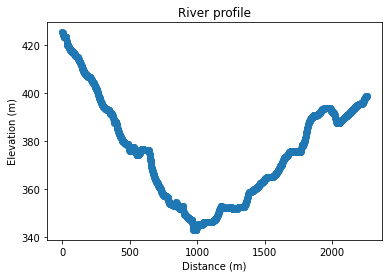

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(prof1_x, prof1_y)
plt.title("River profile")
plt.xlabel("Distance (m)")
plt.ylabel("Elevation (m)")

In [ ]:
# Create 4 arrays for x and y values of each profile flank

x_left = prof1_x[0:y_minpos]
y_left = prof1_y[0:y_minpos]
x_right = prof1_x[y_minpos:-1].dropna()
y_right = prof1_y[y_minpos:-1].dropna()

Text(0, 0.5, 'Elevation (m)')

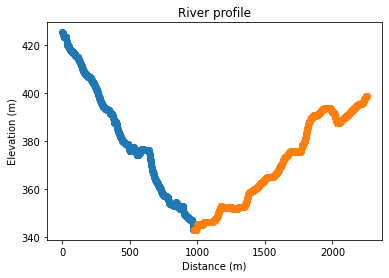

In [ ]:
# Visualize the two half profiles 

plt.scatter(x_left , y_left)
plt.scatter(x_right, y_right)

plt.title("River profile")
plt.xlabel("Distance (m)")
plt.ylabel("Elevation (m)")

# For future work...

In the future, I would add a block of code here to clean up the "tails" on either side of the river profile so these extraneous data points don't interfere with the successive power fit code. One possible way to do this would be to create a new array that contains information on the slopes between points. Then we would go through that array and remove multiple points across which the slope is 0, or close. 

# Run the glaciality algorithm

The following code fits a power law to each profile half and returns the glaciality index, b. The paper goes into more detail about the meaning of this value, but briefly, this value is a way of quantitatively describing the flank of valley walls from the valley profiles (or cross-sections). An index of 1 means straight valleys walls that form a V (fluvially formed), and the indices get larger as the walls become more rounded into a U (glacially formed).

This code was adapted from https://stackoverflow.com/questions/10181151/trying-to-get-reasonable-values-from-scipy-powerlaw-fit

In [ ]:
import numpy as np
from scipy.optimize import least_squares
from scipy.optimize import leastsq

In [ ]:
def fitfunc(p, x):
    return  p[0] * (x ** p[1])
def errfunc(p, x, y):
    return y - fitfunc(p, x)

An important step of this code is taking the data and forcing it through (0,0). In other words, the minimum of the two-sided profile will become the origin for each flank.

In [ ]:
# FOR RIGHT FLANK
# force data through (0,0)
# add very small factor at end because running algorithm w exactly 0 doesn't work
x_r = x_right-(np.min(x_right))+1e-6
y_r = y_right-(np.min(y_right))+1e-6

# FOR LEFT FLANK
x_l = x_left 
y_l = y_left-(np.min(y_left))+1e-6

# Mirror left flank over x of min y value
# Allows us to later run the same code over both flanks instead of having to write a new algorithm for the left flank
x_l=0+(np.max(x_left)-x_l)+1e-6

Now, we'll double check that both flanks, 1) go through (0,0) and 2) resemble a right flank (meaning we successfully mirrored the left flank).

Text(0, 0.5, 'Elevation (m)')

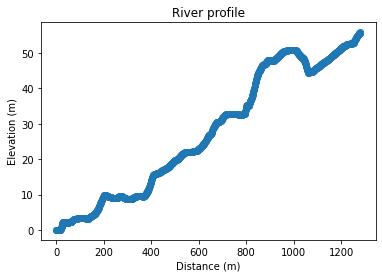

In [ ]:
# RIGHT
plt.scatter(x_r,y_r)

plt.title("River profile")
plt.xlabel("Distance (m)")
plt.ylabel("Elevation (m)")

Text(0, 0.5, 'Elevation (m)')

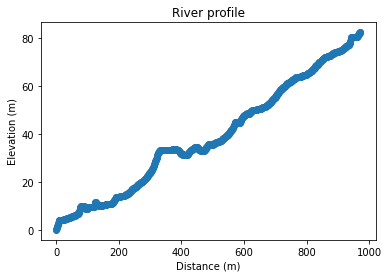

In [ ]:
# LEFT
plt.scatter(x_l,y_l)

plt.title("River profile")
plt.xlabel("Distance (m)")
plt.ylabel("Elevation (m)")

Along the way in our manipulation of the individual flanks, the data got a little wonky and the power fit returns the proper b value but doesn't graph properly when overlain on the river flank profile (most likely from the mirroring of the left flank). This presents issues with plotting the two arrays, so instead we create a fake x array that is the proper length and each value iterates +1 (effectively the same as the data provided by the 10m resolution digital elevation model data).

In [ ]:
# Run the power fit on the right flank
qout,success = leastsq(errfunc, [-1,-0.5], args=(x_r,y_r), maxfev=3000)
out = qout[:]
a = qout[0]
b = qout[1]

In [ ]:
fake_xs = np.arange(0,np.size(x_r),1)

a= 0.02049443441081457 b= 1.1128664461514188


Text(0, 0.5, 'Elevation (m)')

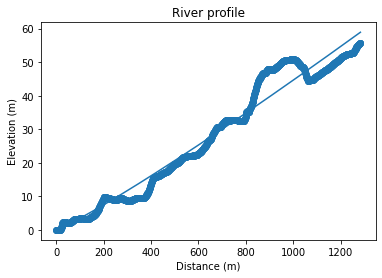

In [ ]:
print('a=',a,"b=",b)
plt.scatter(x_r,y_r)
plt.plot(a * (fake_xs ** b))

plt.title("River profile")
plt.xlabel("Distance (m)")
plt.ylabel("Elevation (m)")

In [ ]:
# run the power fit on the left flank, rename variables to avoid bugs in the code
qout_l,success_l = leastsq(errfunc, [-1,-0.5], args=(x_l,y_l), maxfev=3000)
out_l = qout_l[:]
a_l = qout_l[0]
b_l = qout_l[1]

print('a=',a_l,"b=",b_l)

a= 0.050140908012146226 b= 1.072537041912273


a= 0.050140908012146226 b= 1.072537041912273


Text(0, 0.5, 'Elevation (m)')

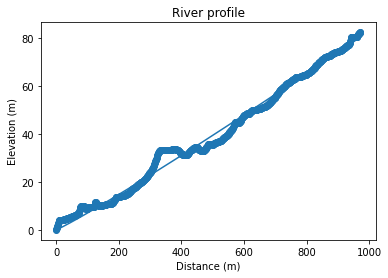

In [ ]:
fake_xs_l = np.arange(0,np.size(x_l),1)

print('a=',a_l,"b=",b_l)
plt.scatter(x_l,y_l)
plt.plot(a_l * (fake_xs_l ** b_l))

plt.title("River profile")
plt.xlabel("Distance (m)")
plt.ylabel("Elevation (m)")

# Tabulate the glaciality indexes

Now we will tabulate the glaciality values from each profile into a single table to make the data easier to analyze. I have included data source to help differentiate NY and CA profiles.

In [ ]:
# HOW DO I KEEP PREVIOUS RUN VALUES STORED IN DATAFRAME??
# Update the table with all the new values
avg = (b + b_l)/2
df2 = pd.DataFrame({"Data Source":[file_name],
                    "Right flank":[b],
                   "Left flank": [b_l],
                    "Average": [avg]})
df_final = df_final.append(df2)

In [ ]:
df_final

,Data Source,Right flank,Left flank,Average
0,/content/drive/MyDrive/Colab Notebooks/EARS33_...,0.914573,0.881335,0.897954
0,/content/drive/MyDrive/Colab Notebooks/EARS33_...,1.112866,1.072537,1.092702


# Data Analysis/Reflection

Now we will analyze these data against known erosion rates for the given watersheds. Erosion rates were taken from https://octopusdata.org and the watersheds are named Upper Susquehanna (NY) and Northern California Coastal (CA). The Pracisek paper this data tutorial was based on draws the conclusion that landforms that fully transition from U-shaped valleys to V-shaped valleys are found in areas where rock uplift and erosion rates are high. In other words, we expect for b values to be lower in CA (where we know the erosion rates are higher from Octopus data and the uplift rates are higher from general tectonic understanding of the US). We expect higher b values and more U-shaped valleys in the NY watershed. 

**In class, we discussed the idea of steady-state assumption or landscape equilibrium in regards to fluvial systems in areas of tectonic uplift. What we learned is that rivers have a tendency to maintain equilibrium. Therefore, in areas of high uplift rates, these rivers experience increased erosion rates in order to incise their valleys to steady-state. This concept is exactly what the Prasicek paper is drawing on. We see how these characteristics of a landscape are connected in the Prasicek paper and we will draw on this connection in the response to the following question(s). 

We know from the Octopus data that the Be-10 erosion rates are as follows: 

NY watershed -- 7.98, 3.97, 23.08 mm/kyr

CA watershed -- 111.3, 93.66 mm/kyr

Next, after running every profile provided for each watershed and analyzing the tabulated data above, the average flank glaciality values (b) are as follows: 

NY watershed -- 1.143

CA watershed -- 0.990

With this information, as well as what you learned from skimming the Prasicek et al. paper linked at the top of this tutorial, how do you make sense of the data we have produced/gathered for each watershed? Do these data support or reject Prasicek et al's assertion that rock uplift, erosion rates, and the persistence of U-shaped valleys are all connected? In short, write a brief (~4 sentence) response on how you make sense of all of this data in junction with one another.


# Response

To reiterate known aspects of geomorphology, we know that: 
1) glaciers form U-shaped valleys during glacial periods
2) rivers inhabit these valleys during interglacial periods
3) sometimes these valley profiles are reshaped within the interglacial period to V-shaped valleys and other times U-shaped valleys persist through interglacial periods. 

Prasicek et al. hypothesizes that the answer behind this phenomenon can be found in the deformation of Earth's surface. After conducting a study in the Southern Alps of New Zealand, these researchers conclude that "the glacial imprint on topography diminishes in proportion to the rock uplift rate" and that "the landform transformed entirely from U-shaped to V-shaped since the LGM (last glaical maximum) where rock uplift and erosion rate is high". 

We know from the Octopus data that the erosion rates are about an order of magnitude higher in the CA watershed compared to the NY watershed. We also know that the west coast in more tectonically active presently compared to the east coast. Using Prasicek et al's conclusion, we would expect the valleys to be more V-shaped in the CA watershed and more U-shaped in the NY watershed. 

From our averaged flank values, this is true (although the avg b values are somewhat comparable). In order to further support the Prasicek paper in the future, we would want to take more river profiles across more watersheds in order to produce any meaningful data. However, our minimal data do seem to point to the fact that there could be a connection between erosion rate, rock uplift, and valley profiles. 